In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/ML-project/data')

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from sklearn.preprocessing import train_test_split as split
import seaborn as sns


!ls

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


build		       shops.csv		      test.csv
item_categories.csv    spark-2.4.5-bin-hadoop2.7      trainset_with_grid.csv
items.csv	       spark-2.4.5-bin-hadoop2.7.tgz  xgb_submission.csv
LightGBM	       submission_modparams1.csv      xgb_test.pickle
sales_train.csv        submission_modparams1.gsheet   xgb_train.pickle
sample_submission.csv  submission_trial.csv


In [0]:
train_path = "sales_train.csv"
test_path = "test.csv"
items_path = "items.csv"
shops_path = "shops.csv"
item_cat_path = "item_categories.csv"

In [0]:
items = pd.read_csv(items_path)
cats = pd.read_csv(item_cat_path)
shops = pd.read_csv(shops_path)
train = pd.read_csv( train_path )
test = pd.read_csv( test_path )

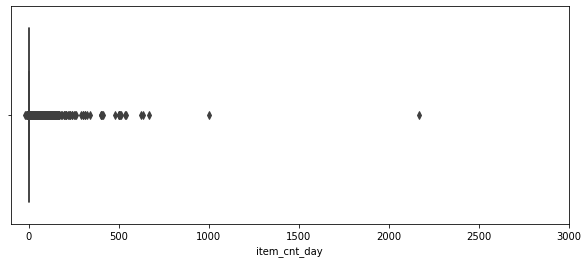

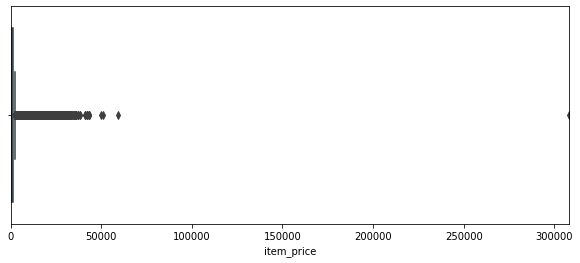

2935849
2
12
1
2935846


In [6]:
#remove outliers
plt.figure(figsize = (10,4))
plt.xlim(-100, 3000)
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,4) )
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot( x = train.item_price )
plt.show()

print(train.shape[0])
print(len( train[train.item_cnt_day >999 ] ))
print( len(train[ train.item_cnt_day > 500  ]) )
print(len(train[train.item_price >100000 ]))
train = train[(train.item_price < 100000 )& (train.item_cnt_day < 1000)]
print(train.shape[0])

In [7]:
#remove items with price < 0 and set items with count less that 1 to 0
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0
print(train.shape)

(2935845, 6)


In [0]:
train.loc[train.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
train.loc[train.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

In [9]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
category = []
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )
    if len(shops[shops.category == cat]) > 4:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "etc" )
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )

Орджоникидзе, 2
ТЦ 28
ТРК 5
ТРЦ 11
(Плехановская, 1
Торговля 1
ул. 2
ЧС 1
"Распродажа" 1
МТРЦ 1
Магазин 1
ТК 5
склад 1
etc 11
ТЦ 28
ТРК 5
ТРЦ 11
ТК 5


In [0]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [11]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
cats.shape
category = []
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))
    if len(cats[cats.type_code == cat]) > 4: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))

PC 1
Аксессуары 7
Билеты 1
Доставка 1
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6
Служебные 2
Чистые 2
Элементы 1
etc 8
Аксессуары 7
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6


In [0]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

In [0]:
import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [14]:
items = pd.read_csv(items_path)

items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.


In [0]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [16]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
print( group_sum.reset_index() )
group_sum = group_sum.reset_index()

        type  item_id
0          0    17661
1        5c5        1
2        5c7        2
3        5f4        1
4        6dv        1
5        6jv        1
6        6l6        1
7    android        3
8        hm3        1
9        j72        4
10       kf6        1
11       kf7        1
12       kg4        1
13       mac       43
14        pc     2628
15        ps       79
16       ps2        2
17       ps3      611
18       ps4      174
19       psp      115
20       s3v        1
21       s4v        1
22   xbox360      466
23   xboxone      123
24      англ        1
25        рс       14
26   русская        1
27    только        9
28     цифро        1
29  цифровая      222


In [17]:
drop_cols = []
for cat in group_sum.type.unique():
#     print(group_sum.loc[(group_sum.type == cat), "item_id"].values[0])
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
drop_cols

['5c5',
 '5c7',
 '5f4',
 '6dv',
 '6jv',
 '6l6',
 'android',
 'hm3',
 'j72',
 'kf6',
 'kf7',
 'kg4',
 'ps2',
 's3v',
 's4v',
 'англ',
 'рс',
 'русская',
 'только',
 'цифро']

In [18]:
items.name2 = items.name2.apply( lambda x: "etc" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [19]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

11.684714794158936

In [0]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [21]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)
time.time() - ts

5.888008117675781

In [22]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.08526229858398438

In [23]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

4.20747447013855

In [0]:
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [25]:
ts = time.time()

matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


21.949529886245728

In [26]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


10.53590989112854

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


26.090733289718628

In [28]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


26.35098099708557

In [29]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


37.7530415058136

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


date_shop_subtype_avg_item_cnt


13.843871593475342

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


13.944461822509766

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


21.840830326080322

In [33]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


308.81537795066833

In [34]:

ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


16.207764625549316

In [35]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,2,27,1.0,4,0,19,76,42,10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0,2,28,0.0,4,0,30,107,42,55,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0,2,29,0.0,4,0,23,123,42,16,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0,2,32,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,45,18454,0.0,4,20,55,4,42,2,7,1.0,0.0,0.0,0.259033,0.045441,0.023254,0.071411,0.126709,0.129395,0.13916,1.0,0.0,0.0,0.126831,0.135376,0.5,-0.475098,51790.574219
11056273,34,45,16188,0.0,4,20,64,4,42,42,8,0.0,0.0,NaN,0.259033,0.022720,0.069763,NaN,0.126709,0.129395,NaN,0.0,0.0,NaN,0.094482,0.135376,0.0,0.081116,51790.574219
11056274,34,45,15757,0.0,4,20,55,4,42,2,7,0.0,0.0,0.0,0.259033,0.113647,0.069763,0.095215,0.126709,0.129395,0.13916,0.0,0.0,0.0,0.126831,0.135376,0.0,0.155884,51790.574219
11056275,34,45,19648,0.0,4,20,40,4,1367,4,5,0.0,0.0,0.0,0.259033,0.045441,0.069763,0.166626,0.126709,0.129395,0.13916,0.0,0.0,0.0,0.083740,0.135376,0.0,-0.091736,51790.574219


In [36]:
matrix.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,19.0,27.0,28.0,29.0,32.0
item_cnt_month,0.0,1.0,0.0,0.0,0.0
shop_category,4.0,4.0,4.0,4.0,4.0
shop_city,0.0,0.0,0.0,0.0,0.0
item_category_id,40.0,19.0,30.0,23.0,40.0
name2,4.0,76.0,107.0,123.0,4.0
name3,42.0,42.0,42.0,42.0,42.0
subtype_code,4.0,10.0,55.0,16.0,4.0


In [0]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [38]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

2.0252859592437744

In [39]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

1.0901718139648438

In [0]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [41]:
data = matrix.copy()
del matrix
gc.collect()

0

In [42]:
data[data["date_block_num"]==34].shape

(214200, 33)

In [0]:
X_train = data[data.date_block_num < 34].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 34]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)


In [0]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    #start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    #end_mem = df.memory_usage().sum() / 1024**2
    #if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
X_train = reduce_mem_usage(pd.DataFrame(X_train))
Y_train = reduce_mem_usage(pd.DataFrame(Y_train))
X_valid = reduce_mem_usage(pd.DataFrame(X_valid))
Y_valid = reduce_mem_usage(pd.DataFrame(Y_valid))
X_test = reduce_mem_usage(pd.DataFrame(X_test))
y_train=Y_train

In [46]:
X_test.shape

(214200, 32)

In [0]:
del data



gc.collect();

In [0]:
# categorical_features = (data.dtypes[data.dtypes.apply(str).str.startswith('int')].index).tolist()
categorical_features = ['item_category_id',
 'shop_id']

In [49]:
!pip install lofo-importance
!pip install pandarallel

In [50]:
!apt-get -qq install --no-install-recommends nvidia-375
!apt-get -qq install --no-install-recommends nvidia-opencl-icd-375 nvidia-opencl-dev opencl-headers
!apt-get -qq install --no-install-recommends git cmake build-essential libboost-dev libboost-system-dev libboost-filesystem-dev
!pip3 install -qq lightgbm --install-option=--gpu

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [51]:
!pip install bayesian-optimization
!pip install scikit-optimize

In [52]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [53]:
!pip install hyperopt

In [54]:
'''
from hyperopt import hp
import lightgbm as lgb
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import tpe
from hyperopt.pyll.base import scope
# Algorithm
tpe_algorithm = tpe.suggest

N_FOLDS = 5

# Create the dataset
train_set = lgb.Dataset(X_train,Y_train['item_cnt_month'].values.astype(np.int32), free_raw_data=False)

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    cv_results = lgb.cv(params, train_set, nfold = n_folds, num_boost_round = 10000, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
  
    # Extract the best score
    best_score = max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1-best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': 'gbdt',
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
    'min_data_in_leaf' : scope.int(hp.quniform('min_data_in_leaf', 0, 20, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),                         
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'bin_construct_sample_cnt' : scope.int(hp.quniform('bin_construct_sample_cnt', 1, 40000, 1))
}
MAX_EVALS = 1
bayes_trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)
'''

'\nfrom hyperopt import hp\nimport lightgbm as lgb\nfrom hyperopt import fmin\nfrom hyperopt import Trials\nfrom hyperopt import tpe\nfrom hyperopt.pyll.base import scope\n# Algorithm\ntpe_algorithm = tpe.suggest\n\nN_FOLDS = 5\n\n# Create the dataset\ntrain_set = lgb.Dataset(X_train,Y_train[\'item_cnt_month\'].values.astype(np.int32), free_raw_data=False)\n\ndef objective(params, n_folds = N_FOLDS):\n    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""\n    \n    # Perform n_fold cross validation with hyperparameters\n    # Use early stopping and evalute based on ROC AUC\n    cv_results = lgb.cv(params, train_set, nfold = n_folds, num_boost_round = 10000, \n                        early_stopping_rounds = 100, metrics = \'auc\', seed = 50)\n  \n    # Extract the best score\n    best_score = max(cv_results[\'auc-mean\'])\n    \n    # Loss must be minimized\n    loss = 1-best_score\n    \n    # Dictionary with information for evaluation\n    return {\'loss\': 

In [55]:
'''
from hyperopt import hp
import lightgbm as lgb
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import tpe, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
# Algorithm
tpe_algorithm = tpe.suggest
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'max_depth': int(params['max_depth']),
        'lambda_l2': '{:.3f}'.format(params['lambda_l2']),
        'lambda_l1': '{:.3f}'.format(params['lambda_l1'])
        'learning_rate' : '{:.3f}'.format.params['learning_rate'],
         'feature_fraction' :  '{:.3f}'.format.params['feature_fraction'],
         'bagging_fraction' : '{:.3f}'.format.params['bagging_fraction'],
         'max_bin' : int(round(params['max_bin'])),
          'min_data_in_leaf' : int(round(params['min_data_in_leaf'])),
         'min_sum_hessian_in_leaf' : params['min_sum_hessian_in_leaf'] ,           
          'subsample' ='{:.3f}'.format.params['subsample']



    }
    
    reg = lgb.LGBMRegressor(
        n_estimators=10,
        #learning_rate=0.01,
        **params
    )
    
    eval_set  = [( X_train, Y_train), ( X_valid, Y_valid)]

    reg.fit(X_train, Y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=100,verbose=True)

    pred = reg.predict(X_valid)
    mse_scr = mean_squared_error(Y_valid, pred)
    #print ("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }



    #score = cross_val_score(reg, X_train,Y_train['item_cnt_month'].values.astype(np.int32), scoring='neg_mean_squared_error', cv=KFold(n_splits=5)).mean()
    #print("rmse_mean {:.3f} params {}".format(score, params))
    #return score

space = {
    'num_leaves': hp.quniform('num_leaves', 10, 50, 5),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 30, 3),
    'max_depth': hp.quniform('max_depth', 2, 30, 5),
    'lambda_l1': hp.uniform('lambda_l1', 0.01, 0.3)




      'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'max_depth': int(params['max_depth']),
        'lambda_l2': '{:.3f}'.format(params['lambda_l2']),
        'lambda_l1': '{:.3f}'.format(params['lambda_l1'])
        'learning_rate' : '{:.3f}'.format.params['learning_rate'],
         'feature_fraction' :  '{:.3f}'.format.params['feature_fraction'],
         'bagging_fraction' : '{:.3f}'.format.params['bagging_fraction'],
         'max_bin' : int(round(params['max_bin'])),
          'min_data_in_leaf' : int(round(params['min_data_in_leaf'])),
         'min_sum_hessian_in_leaf' : params['min_sum_hessian_in_leaf'] ,           
          'subsample' ='{:.3f}'.format.params['subsample']


}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print(best)
'''

'\nfrom hyperopt import hp\nimport lightgbm as lgb\nfrom hyperopt import fmin\nfrom hyperopt import Trials\nfrom hyperopt import tpe, STATUS_OK\nfrom hyperopt.pyll.base import scope\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import train_test_split, KFold\nfrom sklearn.metrics import mean_squared_error\n# Algorithm\ntpe_algorithm = tpe.suggest\ndef objective(params):\n    params = {\n        \'num_leaves\': int(params[\'num_leaves\']),\n        \'min_data_in_leaf\': int(params[\'min_data_in_leaf\']),\n        \'max_depth\': int(params[\'max_depth\']),\n        \'lambda_l2\': \'{:.3f}\'.format(params[\'lambda_l2\']),\n        \'lambda_l1\': \'{:.3f}\'.format(params[\'lambda_l1\'])\n        \'learning_rate\' : \'{:.3f}\'.format.params[\'learning_rate\'],\n         \'feature_fraction\' :  \'{:.3f}\'.format.params[\'feature_fraction\'],\n         \'bagging_fraction\' : \'{:.3f}\'.format.params[\'bagging_fraction\'],\n         \'max_bin\' : int(round(

In [56]:
'''
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
import lightgbm as lgb

yT = Y_train['item_cnt_month'].values.astype(np.int32)

def bayes_parameter_opt_lgb(X_train, yT, init_round=15, opt_round=25, n_folds=5, random_seed=42,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X_train, label=yT, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample,
               bagging_seed, lambda_l2, lambda_l1  ):
        params = {'application':'regression', 'metric':'rmse' }
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_bin))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        params['bagging_seed'] = int(round(bagging_seed))
        params['lambda_l2'] = max(min(lambda_l2, 1), 0)
        params['lambda_l1'] = max(min(lambda_l1, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['rmse'])
        print(cv_result)
        return max(cv_result['rmse-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.0070,0.0080),
                                            'num_leaves': (80, 1024),
                                            'feature_fraction': (0.3, 0.5),
                                            'bagging_fraction': (0.3, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(240,260),
                                            'min_data_in_leaf': (2, 30),
                                            'min_sum_hessian_in_leaf':(0,100),
                                            'subsample':(0,1),
                                            'bagging_seed': (0,50),
                                            'lambda_l2': (0,1),
                                            'lambda_l1': (0,1)
                                            
                                           
                                           }, random_state=42)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X_train, yT, init_round=5, opt_round=10, n_folds=5, random_seed=42,n_estimators=5000)
'''


'\nfrom bayes_opt import BayesianOptimization\nfrom skopt  import BayesSearchCV \nimport lightgbm as lgb\n\nyT = Y_train[\'item_cnt_month\'].values.astype(np.int32)\n\ndef bayes_parameter_opt_lgb(X_train, yT, init_round=15, opt_round=25, n_folds=5, random_seed=42,n_estimators=10000, output_process=False):\n    # prepare data\n    train_data = lgb.Dataset(data=X_train, label=yT, free_raw_data=False)\n    # parameters\n    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample,\n               bagging_seed, lambda_l2, lambda_l1  ):\n        params = {\'application\':\'regression\', \'metric\':\'rmse\' }\n        params[\'learning_rate\'] = max(min(learning_rate, 1), 0)\n        params["num_leaves"] = int(round(num_leaves))\n        params[\'feature_fraction\'] = max(min(feature_fraction, 1), 0)\n        params[\'bagging_fraction\'] = max(min(bagging_fraction, 1), 0)\n        params[\'max_depth\'] =

In [57]:
'''
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params=opt_params[1]

opt_params
'''

'\nopt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))\nopt_params[1][\'max_depth\'] = int(round(opt_params[1][\'max_depth\']))\nopt_params[1][\'min_data_in_leaf\'] = int(round(opt_params[1][\'min_data_in_leaf\']))\nopt_params[1][\'max_bin\'] = int(round(opt_params[1][\'max_bin\']))\nopt_params=opt_params[1]\n\nopt_params\n'

In [0]:


import numpy as np
import pandas as pd
import dateutil
import datetime as dt
from datetime import date
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc
from tqdm.notebook import tqdm
import pickle
import statsmodels.api as sm
from pylab import rcParams
from itertools import permutations, product
import time
import lightgbm as lgb


from lofo import LOFOImportance, FLOFOImportance, Dataset, plot_importance

from sklearn.metrics import (mean_squared_log_error, mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold
import warnings

pandarallel.initialize()
ts = time.time()

kf = KFold(n_splits = 5, random_state=42)
resu1 = 0
impor1 = 0
resu3_mae=0
y_pred = 0
y_final_test = 0
stack_train = np.zeros([X_train.shape[0], ])
models = []
# params = {'num_leaves': 70,
#           'objective': 'regression',
#           'learning_rate': 0.1,
#           "boosting": "dart",
#           "bagging_freq": 5,
#           "bagging_fraction": 0.1,
#           "feature_fraction": 0.9,
#           "num_rounds": 600,
#           # 'max_depth':10
#           }

RAND_SEED = 42

params =  {'num_leaves': 2**8, #'max_depth': 19, 
              'max_bin': 250, 
              'n_estimators': 5000,
              'bagging_freq': 1, 'bagging_fraction': 0.7135681370918421, 
              'feature_fraction': 0.49446461478601994, #'min_data_in_leaf': 2**8, # 88
              'learning_rate': 0.0075,
              'min_data_in_leaf': 5,
              'num_threads': 16, 
                #'device' : 'gpu',
              'min_sum_hessian_in_leaf': 6,
              'random_state' : RAND_SEED,
              'bagging_seed' : 42,
              'boost_from_average' : 'true',
              'metric' : 'rmse',
              'tree_learner' : 'voting',
              'top_k' : 40,
              #'lambda_l1': 0.3877650083876222,
              #'lambda_l2': 0.9370034593829282,
              'verbose' : 1}


prms2={'bagging_fraction': 0.7956508044572318,
 'feature_fraction': 0.11440914600706172,
 'learning_rate': 0.007969909852161994,
 'max_bin': 257,
 'max_depth': 10,
 'min_data_in_leaf': 7,
 'min_sum_hessian_in_leaf': 18.34045098534338,
 'num_leaves': 367,
 'subsample': 0.5247564316322378}


    
for train_index, test_index in tqdm(list(kf.split(X_train, y_train))):
    print(train_index)
    print(test_index)
    X_train2 = X_train.iloc[train_index, :]
    y_train2 = y_train.iloc[train_index]
    X_test2 = X_train.iloc[test_index, :]
    y_test2 = y_train.iloc[test_index]
    
    d_training = lgb.Dataset(X_train2, label=y_train2,
                             categorical_feature=categorical_features,
                             free_raw_data=False)
    d_test = lgb.Dataset(X_test2, label=y_test2,
                         categorical_feature=categorical_features,
                         free_raw_data=False)
    
    clf = lgb.train(params, train_set=d_training, num_boost_round=1000,
                      valid_sets=[d_training, d_test], verbose_eval=25,
                      early_stopping_rounds=50)

    models.append(clf)
    temp_predict = clf.predict(X_test2, num_iteration=clf.best_iteration)
    stack_train[test_index] = temp_predict

    y_pred += clf.predict(X_test, num_iteration=clf.best_iteration)/5
    y_final_test += clf.predict(X_test, num_iteration=clf.best_iteration)/5
    mse = mean_squared_error(y_test2, temp_predict)
    mae = mean_absolute_error(y_test2, temp_predict)

    resu1 += mse/5
    resu3_mae += mae/5 
    impor1 += clf.feature_importance()/5
    del X_train2, y_train2, X_test2, y_test2; gc.collect()

print('xxxxxxxxx',resu1,resu3_mae)
# model = lgb.LGBMRegressor(**params)


# # model = XGBRegressor(
# #     max_depth=10,
# #     n_estimators=1000,
# #     min_child_weight=0.5, 
# #     colsample_bytree=0.8, 
# #     subsample=0.8, 
# #     eta=0.1,
# #      tree_method='gpu_hist',
# #     seed=42)
# # X_valid=X_train.iloc[train_index, :]
# model.fit(
#     X_train, 
#     Y_train, 

#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, )
#     # early_stopping_rounds = 50)

time.time() - ts

/usr/local/lib/python3.6/dist-packages/lofo/lofo_importance.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[1868923 1868924 1868925 ... 9344609 9344610 9344611]
[      0       1       2 ... 1868920 1868921 1868922]


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.13589	valid_1's rmse: 1.09856
[50]	training's rmse: 1.06279	valid_1's rmse: 1.04251
[75]	training's rmse: 1.00618	valid_1's rmse: 0.999786
[100]	training's rmse: 0.962626	valid_1's rmse: 0.967599
[125]	training's rmse: 0.929612	valid_1's rmse: 0.943308
[150]	training's rmse: 0.902251	valid_1's rmse: 0.924549
[175]	training's rmse: 0.881241	valid_1's rmse: 0.91016
[200]	training's rmse: 0.864605	valid_1's rmse: 0.900218
[225]	training's rmse: 0.851429	valid_1's rmse: 0.892273
[250]	training's rmse: 0.840603	valid_1's rmse: 0.885513
[275]	training's rmse: 0.831395	valid_1's rmse: 0.88041
[300]	training's rmse: 0.822902	valid_1's rmse: 0.876531
[325]	training's rmse: 0.815524	valid_1's rmse: 0.873216
[350]	training's rmse: 0.809126	valid_1's rmse: 0.87049
[375]	training's rmse: 0.803261	valid_1's rmse: 0.868516
[400]	training's rmse: 0.797885	valid_1's rmse: 0.866784
[425]	training's rmse: 0.793504	valid

In [0]:
# # test = pd.read_csv('../input/test.csv')
# test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/test.csv')

# good_sales = test_df.merge(train, on=['item_id','shop_id'], how='inner').dropna()
# good_pairs = test_df[test_df['ID'].isin(good_sales['ID'])]
# no_data_items = test_df[~(test_df['item_id'].isin(train['item_id']))]


# print('1. Number of good pairs:', len(good_pairs))
# print('2. No Data Items:', len(no_data_items))
# print('3. Only Item_id Info:', len(test_df)-len(no_data_items)-len(good_pairs))

In [0]:
# test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/test.csv')
# # submission=pd.DataFrame
# submission=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/submission (2).csv')

# for i in submission:
#   print(i)

# # for i in range(214200):
# #   if i in good_pairs['ID']:
# #     df1=pd.DataFrame({
# #         "ID": i, 
# #         "item_cnt_month": [y_final_test[i]]})
# #     submission.append(df1)
# #   else:
# #     df1=pd.DataFrame({"ID": i, 
# #     "item_cnt_month": [0]})
# #     submission.append(df1)
# # print(submission)

# # submission = pd.DataFrame({
# #     "ID": test_df.index, 
# #     "item_cnt_month": y_final_test
# # })
# # submission.to_csv('submission.csv', index=False)

In [0]:
# test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/test.csv')


# submission_xgboostlstm=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/XGBOOST_LSTM_submission.csv')
# submission=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/submission (2).csv')

# # submission_xgboostlstm=

# # submission = pd.DataFrame({
# #     "ID": test_df.index, 
# #     "item_cnt_month": y_final_test
# # })
# # submission.to_csv('submission.csv', index=False)

In [0]:
# submission['item_cnt_month'] = (submission['item_cnt_month'] + submission_xgboostlstm['item_cnt_month'])/2

# print('-Save predict')
# submission.to_csv('XGBOOST_LSTM_LGBMsubmission1.csv', index=False)
# # print('output file :','XGBOOST_LSTM_submission','saved')


In [0]:
print(y_final_test[0])

In [0]:
os.chdir('/content/gdrive/My Drive/ML-project/data')

In [0]:
# test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/test.csv')
# # submission=pd.DataFrame
# for i in range(214200):
#   if i in good_pairs['ID']:
#     df1=pd.DataFrame({
#         "ID": i, 
#         "item_cnt_month": [y_final_test[i]]})
#     submission.append(df1)
#   else:
#     df1=pd.DataFrame({"ID": i, 
#     "item_cnt_month": [0]})
#     submission.append(df1)
# # print(submission)

# # submission = pd.DataFrame({
# #     "ID": test_df.index, 
# #     "item_cnt_month": y_final_test
# # })
# # submission.to_csv('submission.csv', index=False)

In [0]:

test_df = pd.read_csv('test.csv')
# # submission=pd.DataFrame
# for i in range(214200):
#   if i in good_pairs['ID']:
#     df1=pd.DataFrame({
#         "ID": i, 
#         "item_cnt_month": [y_final_test[i]]})
#     submission.append(df1)
#   else:
#     df1=pd.DataFrame({"ID": i, 
#     "item_cnt_month": 0})
#     submission.append(df1)
# print(submission)

submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": y_final_test
})
submission.to_csv('submission_modparams1.csv', index=False)

In [0]:
# print(test_df.index,)

In [0]:
# df_fimp = pd.DataFrame()
# df_fimp["feature"] = X_train.columns.values
# df_fimp["importance"] = impor1



# plt.figure(figsize=(15, 10))
# sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
# plt.title("LightGBM Feature Importance")
# plt.tight_layout()


# # Early stopping, best iteration is:
# # [110]	training's l2: 0.723487	valid_1's l2: 0.624898



# # dart: 0.7507965195057723 0.3168247187962057
# # xxxxxxxxx 0.7477004712072799 0.31445062766595816 - 70 leaves
# # xxxxxxxxx 0.7473484451263276 0.3140945278978704 90 leaves

In [0]:
# X_test.shape